In [ ]:
# 다음의 코드를 참고하여 재구성 : 1. https://github.com/dikshantsagar/CGAN-Face-Emotion-Generation 2. https://github.com/gaborvecsei/CDCGAN-Keras 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/Paper/temp/또다른거 진행

/content/drive/My Drive/Colab Notebooks/Paper/temp/또다른거 진행


In [ ]:
import matplotlib
import tensorflow
matplotlib.use('Agg')
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import utils as keras_utils
from tensorflow.keras import optimizers
from tensorflow.keras import datasets
from tensorflow.keras.utils import plot_model
import cdcgan_utils

import pandas as pd
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
import cv2
import glob

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/Paper

/content/drive/My Drive/Colab Notebooks/Paper


In [ ]:
data_name = 'FER'
fake_classes = 100
classes=7
size = 48
input_sizes = (size,size,1)
batch_size = 64
latent_dim = 100
channels = 1
filters = 64

BATCH_SIZE = 128
EPOCHS =100

In [ ]:
# data import
x_train = pd.read_csv(os.path.join(data_name,'X_train.csv'),header=0,index_col=0)
x_valid = pd.read_csv(os.path.join(data_name,'X_private_test.csv'),header=0,index_col=0)
y_train = pd.read_csv(os.path.join(data_name,'y_train.csv'),header=0,index_col=0)
y_valid = pd.read_csv(os.path.join(data_name,'y_private_test.csv'),header=0,index_col=0)


# data handling
x_train = np.array(x_train).reshape([-1,48,48,3]) 
x_valid = np.array(x_valid).reshape([-1,48,48,3]) 

x_train = np.vstack([x_train,x_valid])
y_train  = np.vstack([y_train,y_valid])

# x : -1 ~ 1 centering & scaling
x_train=x_train.astype('float32')/255.
x_train=x_train[:,:,:,1]
x_train=x_train[:,:,:,np.newaxis]

In [ ]:
dataset = [x_train,y_train]

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, Embedding, Reshape, Concatenate, Dropout , LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
n_classes = 7
latent_dim = 100
n_critic=5

In [ ]:
def get_descriminator(filters=64,in_shape=(48,48,1), n_classes=7, channels=1):

  label = Input(shape = (1,))
  li = Embedding(n_classes+1,50)(label)

  li = Dense(in_shape[0]*in_shape[1])(li)

  li = Reshape((in_shape[0],in_shape[1],channels))(li)

  image = Input(shape=in_shape)

  merge = Concatenate()([image, li])

  fe = Conv2D(filters,(3,3), strides=(2,2), padding = 'same')(merge)
  fe = LeakyReLU(0.2)(fe)

  fe = Conv2D(filters*2, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(0.2)(fe)

  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)

  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([image, label], out_layer)

  opt = RMSprop(lr=0.00002,decay=6e-8)
  model.compile(loss='mse', optimizer=opt, metrics=['accuracy','mape'])
 
  return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        400         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 2304)      117504      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 1)]  0                                            
______________________________________________________________________________________________

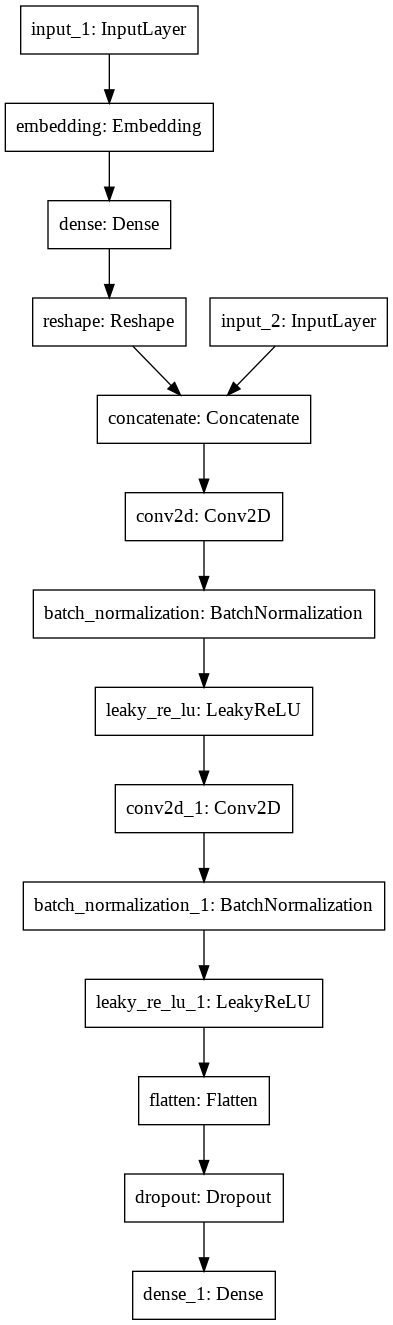

In [ ]:
discmodel = get_descriminator()
discmodel.summary()
plot_model(discmodel)

In [ ]:
def get_generator(filters=64, latent_dim=100, output_sizes=(48,48) , n_classes = 7, channels=1):
    label = Input(shape=(1,))

    li = Embedding(n_classes+1,50)(label)

    li = Dense(output_sizes[0] // 4 * output_sizes[1] // 4 * channels )(li)
    li = Reshape((output_sizes[0] // 4, output_sizes[1] // 4 , channels ))(li)

    latent = Input(shape=(latent_dim,))

    gen = Dense(output_sizes[0] // 4 * output_sizes[1] // 4 * filters * 4)(latent)
    gen = LeakyReLU(0.2)(gen)
    gen = Reshape((output_sizes[0] // 4, output_sizes[1] // 4, filters * 4))(gen)

    merge = Concatenate()([gen, li])

    gen = Conv2DTranspose(filters * 2, (3,3), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(0.2)(gen)
    gen = Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(0.2)(gen)

    out_layer = Conv2D(channels, (3,3), activation='sigmoid', padding='same')(gen)

    model = Model([latent, label], out_layer)
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 36864)        3723264     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        400         input_3[0][0]                    
____________________________________________________________________________________________

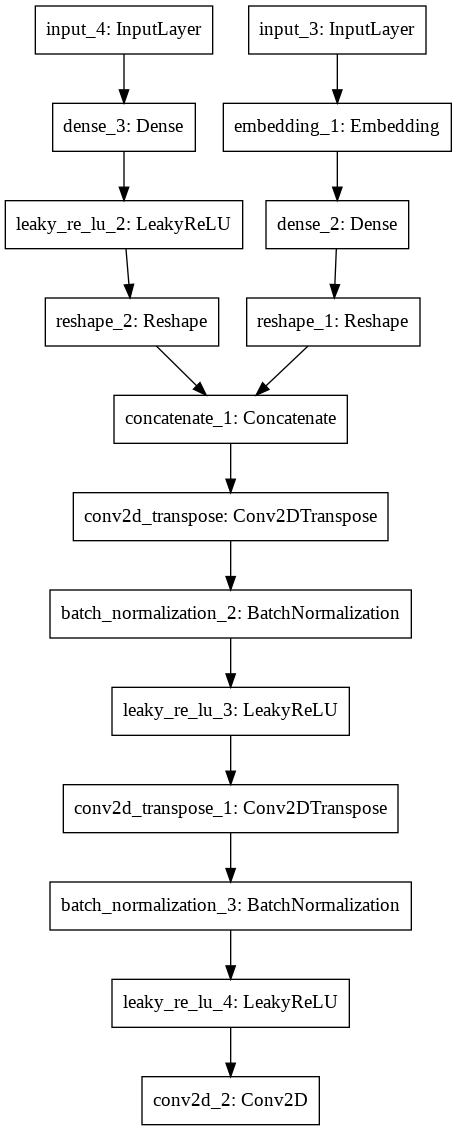

In [ ]:
genmodel = get_generator(filters=filters,latent_dim=latent_dim)
genmodel.summary()
plot_model(genmodel)

In [ ]:
def cgan(genmodel,discmodel):

  discmodel.trainable = False

  g_noise, g_label = genmodel.input
  g_output = genmodel.output

  cgan_output = discmodel([g_output, g_label])

  model = Model([g_noise, g_label], cgan_output)

  opt = RMSprop(lr=0.00002, decay=6e-8)
  model.compile(loss='mse', optimizer=opt, metrics=['accuracy','mape'])
  return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	
	images, labels = dataset

	ix = np.random.randint(0, images.shape[0], n_samples)
	
	X, labels = images[ix], labels[ix]
	
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	
	x_input = np.random.randn(latent_dim * n_samples)
	
	z_input = x_input.reshape(n_samples, latent_dim)
	
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 

def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	
	images = generator.predict([z_input, labels_input])
	
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
def train(genmodel, discmodel, cganmodel, dataset, latent_dim, n_epochs=100, n_batch=64, classes=7):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    iteration = 0


    nb_of_iterations_per_epoch = int(dataset[0].shape[0] / n_batch)
    print("Number of iterations per epoch: {0}".format(nb_of_iterations_per_epoch))
    for i in range(n_epochs):

      pbar = tqdm(desc="Epoch: {0}".format(i), total=dataset[0].shape[0])
      g_losses = []
      d1_losses = []
      d2_losses = []
      g_accuracies = []
      d1_accuracies = []
      d2_accuracies = []
      g_mapes = []
      d1_mapes = []
      d2_mapes = []
      
      for j in range(bat_per_epo):
        
          temp_d1_loss=0
          temp_d2_loss=0 
          temp_d1_acc = 0
          temp_d2_acc = 0
          temp_d1_mape = 0
          temp_d2_mape = 0

          for _ in range(n_critic): # 여기서해야함
              #display.clear_output(wait=True)
              [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
              d_loss1, d_acc1, d_mape1 = discmodel.train_on_batch([X_real, labels_real], y_real)

              temp_d1_loss += d_loss1
              temp_d1_acc += d_acc1
              temp_d1_mape += d_mape1


              [X_fake, labels], y_fake = generate_fake_samples(genmodel, latent_dim, half_batch)
              d_loss2, d_acc2, d_mape2 = discmodel.train_on_batch([X_fake, labels], y_fake)

              temp_d2_loss += d_loss2
              temp_d2_acc += d_acc2
              temp_d2_mape += d_mape2

          temp_d1_loss /= n_critic
          temp_d1_acc /= n_critic
          temp_d1_mape /= n_critic
          temp_d2_loss /= n_critic
          temp_d2_acc /= n_critic
          temp_d2_mape /= n_critic          


          d1_losses.append(temp_d1_loss)
          d1_accuracies.append(temp_d1_acc)
          d1_mapes.append(temp_d1_mape)
          d2_losses.append(temp_d2_loss)
          d2_accuracies.append(temp_d2_acc)
          d2_mapes.append(temp_d2_mape)  


          [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
          y_gan = np.ones((n_batch, 1))
          g_loss, g_acc, g_mape = cganmodel.train_on_batch([z_input, labels_input], y_gan)
          g_losses.append(g_loss)
          g_accuracies.append(g_acc)
          g_mapes.append(g_mape)

          pbar.update(batch_size)
          iteration += 1
      
      
      # Save a generated image for every epoch
      image_grid = cdcgan_utils.generate_image_grid(genmodel, title="Epoch {0}".format(i) , classes=classes, cmap='gray')
      cdcgan_utils.save_generated_image(image_grid, i, 0, "/content/drive/My Drive/Colab Notebooks/Paper/temp/또다른거 진행/lsgan/epoch")

      pbar.close()
      print("Number of iterations: %d "%iteration)
      print("D_real loss: {0}, D_fake loss: {1}, GD loss: {2} // D_real accuracy: {3}, D_fake accuracy: {4}, GD accuracy: {5} // D_real mape: {6}, D_fake mape: {7}, GD mape: {8}".format(np.mean(d1_losses), np.mean(d2_losses), np.mean(g_losses),
                                                                                                                                      np.mean(d1_accuracies), np.mean(d2_accuracies), np.mean(g_accuracies) ,
                                                                                                                                      np.mean(d1_mapes), np.mean(d2_mapes), np.mean(g_mapes) ))
      if i % 10 == 0:
          genmodel.save_weights(os.path.join("/content/drive/My Drive/Colab Notebooks/Paper/temp/또다른거 진행/lsgan/G", str(i)+".h5"))
          discmodel.save_weights(os.path.join("/content/drive/My Drive/Colab Notebooks/Paper/temp/또다른거 진행/lsgan/D", str(i)+".h5"))
      
    return d1_losses,d2_losses,g_losses,d1_accuracies,d2_accuracies,g_accuracies,d1_mapes,d2_mapes,g_mapes

In [ ]:
discmodel = get_descriminator()
genmodel = get_generator(filters=filters,latent_dim=latent_dim)
#genmodel = load_model('/content/drive/My Drive/DL/cgan_generator.h5')

cganmodel = cgan(genmodel,discmodel)

In [ ]:
cganmodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 36864)        3723264     input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        400         input_7[0][0]                    
____________________________________________________________________________________________

In [ ]:
# 0:Anger, 1:Disgust, 2:Fear, 3:Happiness, 4:Sadness, 5:Surprise, 6:Neutral

d1,d2,g,d1_acc,d2_acc,g_acc,d1_mape,d2_mape,g_mape=train(genmodel, discmodel, cganmodel, dataset, latent_dim,n_epochs=500, n_batch=64)

Epoch: 0:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations per epoch: 504


Epoch: 0: 100%|█████████▉| 32192/32287 [00:50<00:00, 773.19it/s]

>1, 504/504, d1=0.000, d2=0.000 g=0.017


Epoch: 1:   0%|          | 0/32287 [00:00<?, ?it/s]

Number of iterations: 504 
D_real loss: 0.018325574380960566, D_fake loss: 0.03972519394075182, GD loss: 0.16178603062694455 // D_real accuracy: 0.9939236111111112, D_fake accuracy: 0.9821428571428571, GD accuracy: 0.9564732142857143


Epoch: 1: 100%|█████████▉| 32256/32287 [00:42<00:00, 784.27it/s]

>2, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 2:   0%|          | 128/32287 [00:00<00:39, 809.68it/s]

Number of iterations: 1008 
D_real loss: 4.567374192429775e-05, D_fake loss: 5.4025147780977693e-05, GD loss: 0.14144344143393325 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 0.9507068452380952


Epoch: 2: 100%|█████████▉| 32256/32287 [00:41<00:00, 766.88it/s]

>3, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 3:   0%|          | 128/32287 [00:00<00:40, 791.31it/s]

Number of iterations: 1512 
D_real loss: 3.371408881534163e-09, D_fake loss: 1.041029866283115e-09, GD loss: 4.954805587425386e-08 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 3: 100%|█████████▉| 32256/32287 [00:41<00:00, 791.60it/s]

>4, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 4:   0%|          | 128/32287 [00:00<00:40, 802.14it/s]

Number of iterations: 2016 
D_real loss: 8.986642005574943e-10, D_fake loss: 6.19723972952476e-11, GD loss: 1.3645346785916963e-09 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 4: 100%|█████████▉| 32256/32287 [00:41<00:00, 787.00it/s]

>5, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 5:   0%|          | 128/32287 [00:00<00:38, 825.64it/s]

Number of iterations: 2520 
D_real loss: 3.2826111283108023e-10, D_fake loss: 4.371990780249107e-11, GD loss: 6.74544598033227e-10 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 5: 100%|█████████▉| 32256/32287 [00:41<00:00, 776.35it/s]

>6, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 6:   0%|          | 128/32287 [00:00<00:41, 779.87it/s]

Number of iterations: 3024 
D_real loss: 2.3088470863916118e-10, D_fake loss: 3.043025759846141e-11, GD loss: 6.58099437323837e-10 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 6: 100%|█████████▉| 32256/32287 [00:41<00:00, 797.43it/s]

>7, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 7:   0%|          | 128/32287 [00:00<00:41, 767.52it/s]

Number of iterations: 3528 
D_real loss: 2.2013402796287796e-10, D_fake loss: 2.3493775310400296e-11, GD loss: 6.03841971547191e-10 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 7: 100%|█████████▉| 32256/32287 [00:41<00:00, 802.57it/s]

>8, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 8:   0%|          | 128/32287 [00:00<00:39, 814.28it/s]

Number of iterations: 4032 
D_real loss: 1.755037139408064e-10, D_fake loss: 1.949158347100369e-11, GD loss: 6.124477161088187e-10 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 8: 100%|█████████▉| 32256/32287 [00:40<00:00, 800.55it/s]

>9, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 9:   0%|          | 128/32287 [00:00<00:40, 801.96it/s]

Number of iterations: 4536 
D_real loss: 1.6487683952398073e-10, D_fake loss: 1.5008625955804603e-11, GD loss: 6.283600261586693e-10 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 9: 100%|█████████▉| 32256/32287 [00:41<00:00, 788.70it/s]

>10, 504/504, d1=0.000, d2=0.000 g=0.000


Epoch: 10:   0%|          | 128/32287 [00:00<00:42, 760.12it/s]

Number of iterations: 5040 
D_real loss: 1.380876945813447e-10, D_fake loss: 1.2747219512797296e-11, GD loss: 6.090337919279901e-10 // D_real accuracy: 1.0, D_fake accuracy: 1.0, GD accuracy: 1.0


Epoch: 10:  16%|█▋        | 5248/32287 [00:06<00:36, 747.79it/s]

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,10))
plt.plot(d1[-100:],label='D1 Loss')
plt.plot(d2[-100:],label='D2 Loss')
plt.plot(g[-100:],label='G Loss')
plt.legend()
plt.show()